<a href="https://colab.research.google.com/github/fartas40/Precipitation-trend-analysis/blob/main/Precipitation_trends(for_khulna_chittagong_dhaka)for%20the%20years%201990-2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

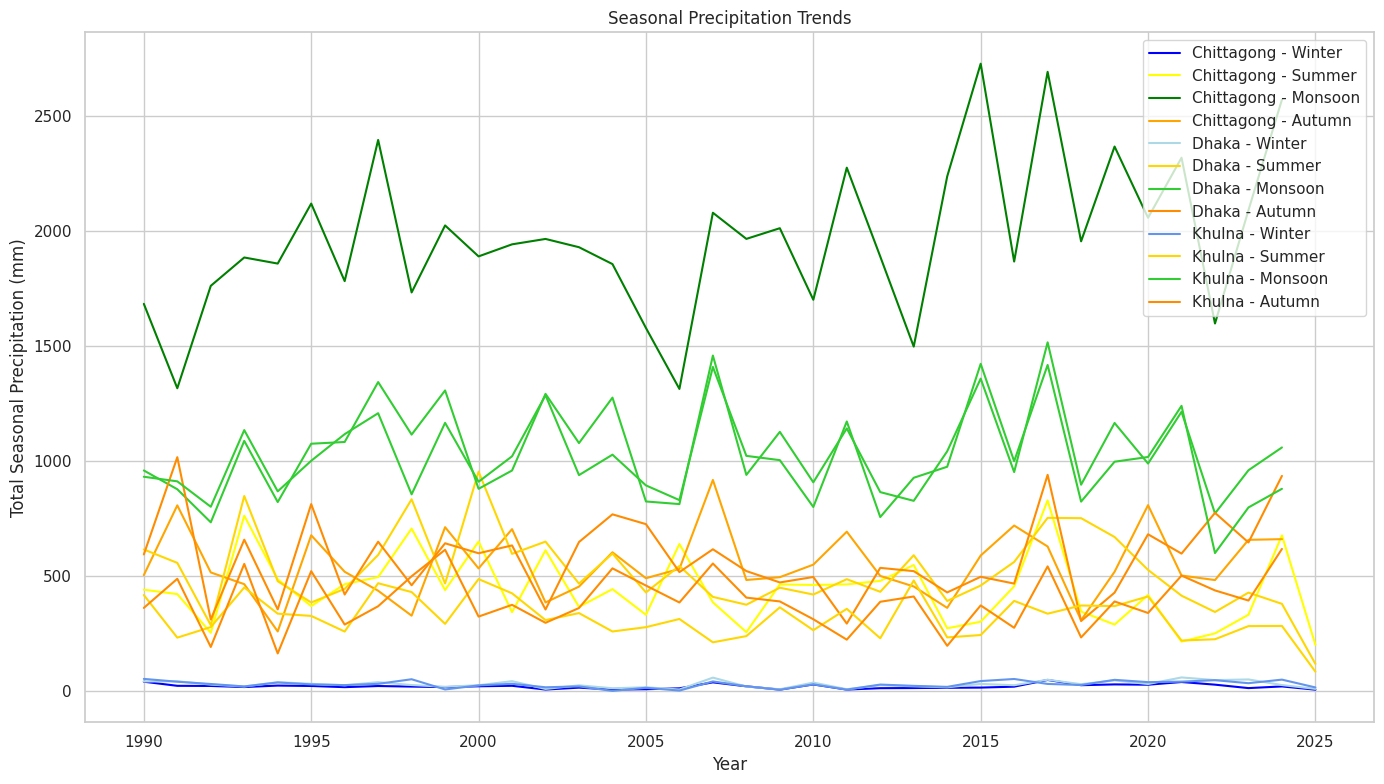


Seasonal Trend Summary:

Winter Linear Trend: 0.3408 mm/year
Winter R-squared: 0.01, p-value: 0.55905

Summer Linear Trend: -11.0109 mm/year
Summer R-squared: 0.101, p-value: 0.05897

Monsoon Linear Trend: 14.9512 mm/year
Monsoon R-squared: 0.054, p-value: 0.17887

Autumn Linear Trend: 3.0561 mm/year
Autumn R-squared: 0.007, p-value: 0.63401



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Install required libraries ---
!pip install -q geemap earthengine-api

# --- Import libraries ---
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from google.colab import files

# --- Authenticate Earth Engine ---
ee.Authenticate()
ee.Initialize()

# --- Define city coordinates ---
cities = {
    'Chittagong': {'lat': 22.3569, 'lon': 91.7832},
    'Dhaka': {'lat': 23.8103, 'lon': 90.4125},
    'Khulna': {'lat': 22.8456, 'lon': 89.5403}
}

# --- Define new season mapping ---
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Summer', 4: 'Summer', 5: 'Summer',
    6: 'Monsoon', 7: 'Monsoon', 8: 'Monsoon',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

# --- Define time chunks (5-year) ---
time_chunks = [(year, year + 4 if year + 4 <= 2025 else 2025) for year in range(1990, 2026, 5)]

# --- Function to fetch city data in chunks ---
def fetch_city_data(city, lat, lon):
    point = ee.Geometry.Point(lon, lat)
    all_df = []

    for start, end in time_chunks:
        dataset = (ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
                   .filterDate(f'{start}-01-01', f'{end}-12-31')
                   .select('precipitation'))

        def extract(image):
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
            value = image.reduceRegion(ee.Reducer.mean(), point, 5000).get('precipitation')
            return ee.Feature(None, {'date': date, 'precipitation': value})

        try:
            features = dataset.map(extract).filter(ee.Filter.notNull(['precipitation']))
            fc = features.getInfo()['features']
        except Exception as e:
            print(f"Skipping {city} from {start} to {end} due to error: {e}")
            continue

        df = pd.DataFrame([{
            'city': city,
            'date': f['properties']['date'],
            'precipitation': f['properties']['precipitation']
        } for f in fc])

        all_df.append(df)

    if all_df:
        df = pd.concat(all_df)
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['season'] = df['month'].map(season_map)
        return df
    else:
        return pd.DataFrame()

# --- Collect data for all cities ---
all_data = pd.concat([
    fetch_city_data(city, coords['lat'], coords['lon'])
    for city, coords in cities.items()
])

# --- Calculate seasonal total precipitation ---
seasonal_totals = all_data.groupby(['year', 'city', 'season'])['precipitation'].sum().reset_index()

# --- Custom color palette for each city/season ---
palette = {
    ('Chittagong', 'Winter'): 'blue',
    ('Chittagong', 'Summer'): 'yellow',
    ('Chittagong', 'Monsoon'): 'green',
    ('Chittagong', 'Autumn'): 'orange',
    ('Dhaka', 'Winter'): 'lightblue',
    ('Dhaka', 'Summer'): 'gold',
    ('Dhaka', 'Monsoon'): 'limegreen',
    ('Dhaka', 'Autumn'): 'darkorange',
    ('Khulna', 'Winter'): '#6495ED',
    ('Khulna', 'Summer'): '#FFD700',
    ('Khulna', 'Monsoon'): '#32CD32',
    ('Khulna', 'Autumn'): '#FF8C00',
}

# --- Plot seasonal precipitation trends ---
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

for city in cities:
    for season in ['Winter', 'Summer', 'Monsoon', 'Autumn']:
        subset = seasonal_totals[(seasonal_totals['city'] == city) & (seasonal_totals['season'] == season)]
        plt.plot(subset['year'], subset['precipitation'],
                 label=f'{city} - {season}', color=palette[(city, season)])

plt.xlabel('Year')
plt.ylabel('Total Seasonal Precipitation (mm)')
plt.title('Seasonal Precipitation Trends')
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute trend statistics for each season (all cities combined) ---
results = []

for season in ['Winter', 'Summer', 'Monsoon', 'Autumn']:
    season_data = seasonal_totals[seasonal_totals['season'] == season]
    yearly_total = season_data.groupby('year')['precipitation'].sum().reset_index()

    slope, intercept, r_value, p_value, std_err = linregress(yearly_total['year'], yearly_total['precipitation'])

    results.append({
        'Season': season,
        'Linear Trend (mm/year)': round(slope, 4),
        'R-squared': round(r_value**2, 3),
        'p-value': round(p_value, 5)
    })

trend_df = pd.DataFrame(results)

# --- Print trend results nicely ---
print("\nSeasonal Trend Summary:\n")
for _, row in trend_df.iterrows():
    print(f"{row['Season']} Linear Trend: {row['Linear Trend (mm/year)']} mm/year")
    print(f"{row['Season']} R-squared: {row['R-squared']}, p-value: {row['p-value']}\n")

# --- Export to CSV ---
csv_file = "updated_seasonal_trend_results.csv"
trend_df.to_csv(csv_file, index=False)
files.download(csv_file)


In [ ]:
# --- Compute trend statistics for each season per city ---
from scipy.stats import linregress

# Store results for each city and season
city_season_results = []

# Loop through each city and season to calculate linear regression
for city in seasonal_totals['city'].unique():
    for season in seasonal_totals['season'].unique():
        subset = seasonal_totals[(seasonal_totals['city'] == city) & (seasonal_totals['season'] == season)]
        if len(subset) >= 2:
            slope, intercept, r_value, p_value, std_err = linregress(subset['year'], subset['precipitation'])
            city_season_results.append({
                'City': city,
                'Season': season,
                'Linear Trend (mm/year)': round(slope, 4),
                'R-squared': round(r_value ** 2, 3),
                'p-value': round(p_value, 5)
            })

# Create a DataFrame with the results
city_season_trend_df = pd.DataFrame(city_season_results)

# --- Print the results cleanly ---
print("\nSeasonal Trend Summary by City:\n")
for city in city_season_trend_df['City'].unique():
    print(f"--- {city} ---")
    for _, row in city_season_trend_df[city_season_trend_df['City'] == city].iterrows():
        print(f"{row['Season']} Linear Trend: {row['Linear Trend (mm/year)']} mm/year")
        print(f"{row['Season']} R-squared: {row['R-squared']}, p-value: {row['p-value']}\n")

# --- Optional: Export to CSV and download ---
csv_file = "seasonal_trend_by_city.csv"
city_season_trend_df.to_csv(csv_file, index=False)

from google.colab import files
files.download(csv_file)



Seasonal Trend Summary by City:

--- Chittagong ---
Autumn Linear Trend: 1.7676 mm/year
Autumn R-squared: 0.015, p-value: 0.48214

Monsoon Linear Trend: 14.073 mm/year
Monsoon R-squared: 0.183, p-value: 0.01047

Summer Linear Trend: -3.7035 mm/year
Summer R-squared: 0.062, p-value: 0.14238

Winter Linear Trend: 0.0159 mm/year
Winter R-squared: 0.0, p-value: 0.92451

--- Dhaka ---
Autumn Linear Trend: 0.6855 mm/year
Autumn R-squared: 0.002, p-value: 0.82421

Monsoon Linear Trend: 1.5022 mm/year
Monsoon R-squared: 0.006, p-value: 0.66268

Summer Linear Trend: -4.5466 mm/year
Summer R-squared: 0.082, p-value: 0.09086

Winter Linear Trend: 0.1447 mm/year
Winter R-squared: 0.011, p-value: 0.54003

--- Khulna ---
Autumn Linear Trend: 0.603 mm/year
Autumn R-squared: 0.003, p-value: 0.76841

Monsoon Linear Trend: -0.624 mm/year
Monsoon R-squared: 0.001, p-value: 0.8515

Summer Linear Trend: -2.7607 mm/year
Summer R-squared: 0.102, p-value: 0.05703

Winter Linear Trend: 0.1802 mm/year
Winter R

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>